In [3]:
from packages.display.core import *
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
%qtconsole

# ALMA Cycle 0

https://www.iram.fr/IRAMFR/ARC/documents/cycle0/ALMA_EarlyScience_Cycle0_HighestPriority.pdf

## 	Project 2011.0.00772.S

### 	

Resq Freq 115.271 MHz

In [25]:
file_path = 'data/2011.0.00772.S/sg_ouss_id/group_ouss_id/member_ouss_id/product/calibrated.ms.contsub.bin4.line.image.fits'
noise_pixel = (250, 175)
train_pixels = [(450, 694)]

In [13]:
img = fits.open(file_path)

meta = img[0].data
hdr = img[0].header

# V axis
naxisv = hdr['NAXIS3']

onevpix = hdr['CDELT3']*0.000001
v0 = hdr['CRVAL3']*0.000001
v0pix = int(hdr['CRPIX3'])
vaxis = onevpix * (np.arange(naxisv)+1-v0pix) + v0

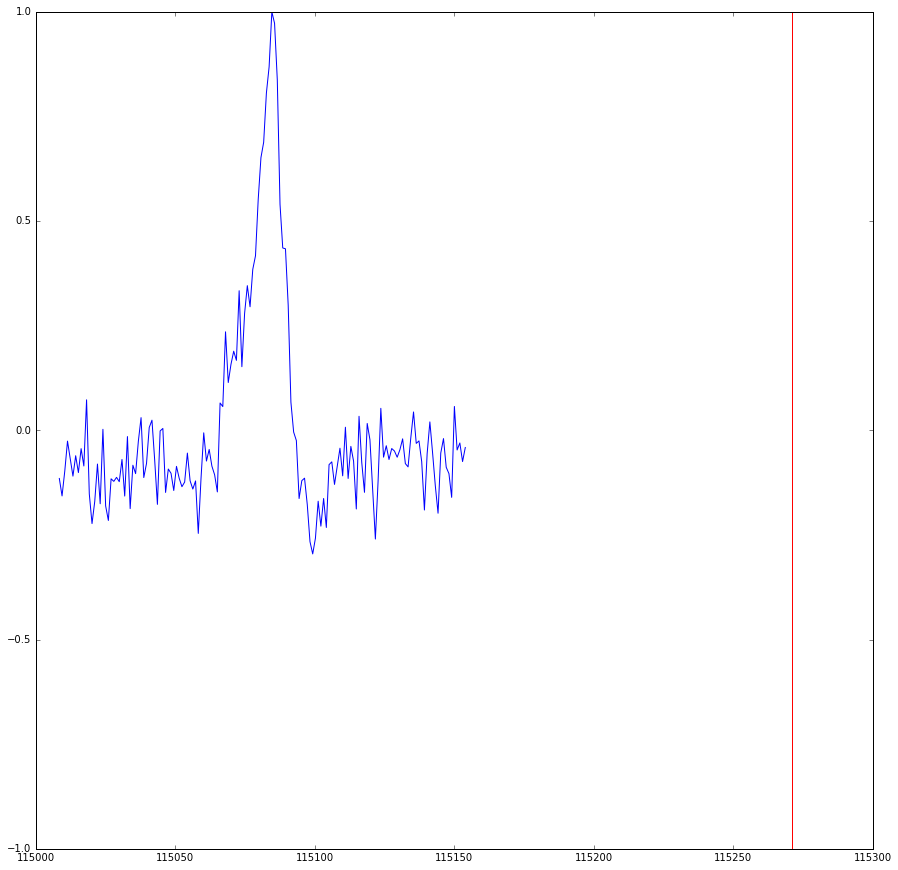

In [35]:
values = meta[0, :, train_pixels[0][0], train_pixels[0][1]] - np.mean(meta[0, :, train_pixels[0][0], train_pixels[0][1]])
values = values/np.max(values)

plt.plot(vaxis, values)
plt.axvline(x=115271, ymin=0, ymax= 1, color='r')

plt.ylim(-1, 1)
gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

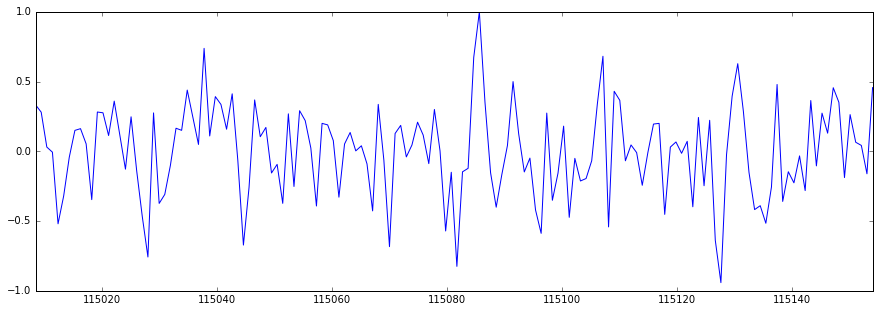

In [26]:
noise = meta[0, :, noise_pixel[0], noise_pixel[1]] - np.mean(meta[0, :, noise_pixel[0], noise_pixel[1]])
noise = noise/np.max(noise)

plt.plot(vaxis, noise)

plt.ylim(-1, 1)
plt.xlim(np.min(vaxis), np.max(vaxis))
gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

To select the isolist, the wavelength range of the cube is obtained, and a searching from theoretical catalog Splatalogue is performed. All the isotopes that have spectral lines on the range of the cube are determinated.

In [27]:
freq_init = vaxis[0]
freq_end = vaxis[-1]

dbpath = 'ASYDO'
dba = packages.asydopy.db.lineDB(dbpath)
dba.connect()
select = "SELECT * FROM Lines WHERE NOT SPECIES LIKE '%-%' AND FREQ > " + str(freq_init) + " AND FREQ < " + str(freq_end)
molist_present = dba.executeSQL(select)
dba.disconnect()

## Creation of Dictionary

We create the words necessary to fit a sparse coding model to the observed spectra in the previous created cube.
It returns a DataFrame with a vector for each theoretical line for each isotope in molist

In [28]:
cube_params = {
  'freq'     : vaxis[naxisv/2],
  'alpha'    : 0,
  'delta'    : 0,
  'spe_bw'   : naxisv*onevpix,
  'spe_res'  : onevpix*v0pix,
  's_f'      : 8,
  's_a'      : 0}

log = sys.stdout
dbpath = 'ASYDO'
dictionary = pd.DataFrame([])

last_code = ""
last_freq = 0

for tuple in molist_present:
    iso = tuple[1]
    univ=packages.display.vu.Universe(log)
    univ.create_source('word-'+ iso)
    s_x = 1
    s_y = 1
    rot = 0
    s_f=cube_params['s_f']
    angle=math.pi
    model=packages.display.vu.IMCM(
        log,dbpath,iso,temp,
        ('normal',s_x, s_y, angle),
        ('skew', cube_params['s_f'], cube_params['s_a']),
        ('linear', angle, rot))
    model.set_radial_velocity(rvel)
    univ.add_component('word-'+ iso, model)
    lines = univ.gen_cube('observerd',
                          cube_params['freq'],
                          cube_params['spe_res'],
                          cube_params['spe_bw'])
    if len(lines.hdulist) > 1:

        for line in lines.hdulist[1].data:

            last_iso = last_code.split('-')[0]
            distance = float(line[0].split('-')[1][1:]) - last_freq

            if(iso != last_iso or \
             (iso == last_iso and distance >= 1)):

                word = np.array(np.zeros(len(lines.get_spectrum())))
                '''
                    line[0] : line_code alias
                    line[1] : relative freq at the window
                '''
                word[line[1]] = 1
                dictionary[line[0]] = word

                last_code = line[0]

            else:
                #
                dictionary.pop(last_code)
                word[line[1]] = 1
                # dictionary[line[0]] = word

                dual_alias = last_code + "&&" + \
                             line[0].split('-')[1]
                #
                dictionary[dual_alias] = word
                # dictionary[dual_alias] = np.sum([dictionary\
                #                     [last_code], word], axis=0)
                # if '&&' in last_code:
                #     dictionary.pop(last_code)

                last_code = dual_alias

            last_freq = float(line[0].split('-')[1][1:])

dictionary.index = get_freq_index_from_params(cube_params)

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Recalibration of Dictionary

C:\Anaconda2\lib\site-packages\spams.py:424: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if D == None:


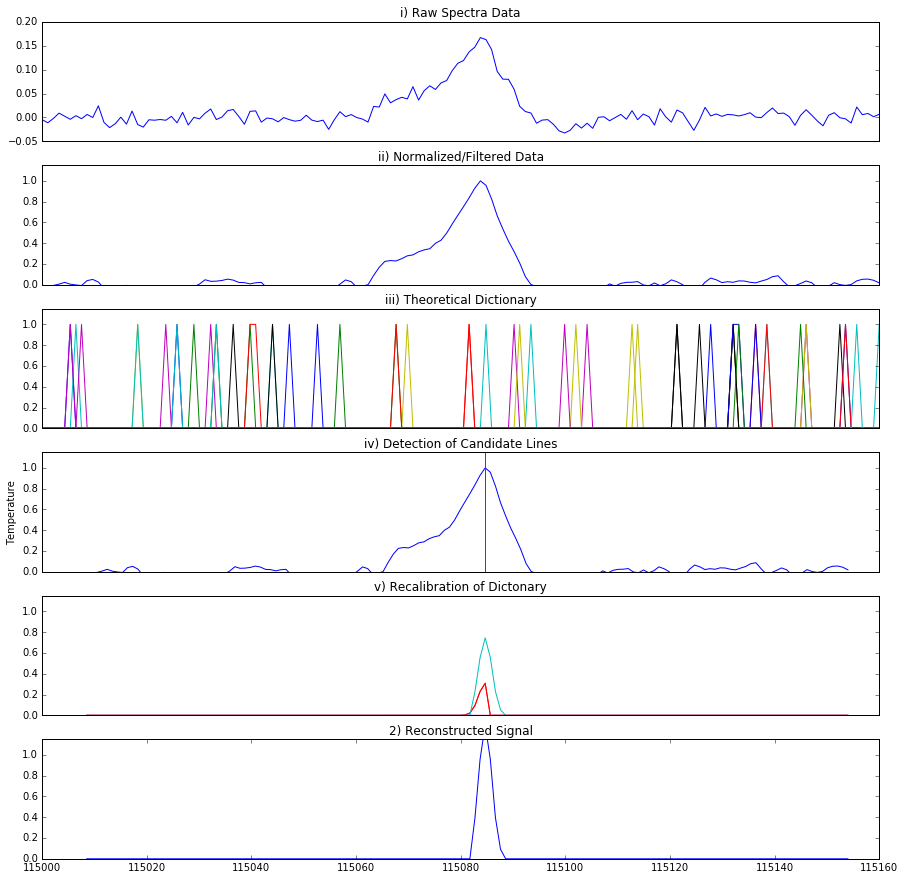

In [29]:
result = []
for train_pixel in train_pixels:
    dictionary_recal, detected_peaks = recal_words(file_path, dictionary, cube_params, 
                                                   train_pixel, noise_pixel)

    X = get_values_filtered_normalized(file_path, train_pixel, cube_params)

    y_train = get_fortran_array(np.asmatrix(X))
    dictionary_recal_fa = np.asfortranarray(dictionary_recal,
                                            dtype= np.double)

    lambda_param = 0
    for idx in range(0, len(detected_peaks)):
        if detected_peaks[idx] != 0:
            lambda_param += 1

    param = {
      'lambda1' : lambda_param,
      # 'L': 1,
      'pos' : True,
      'mode' : 0,
      'ols' : True,
      'numThreads' : -1}

    alpha = spams.lasso(y_train, dictionary_recal_fa, **param).toarray()
    total = np.inner(dictionary_recal_fa, alpha.T)

    pylab.rcParams['figure.figsize'] = (15, 15)

    # Step 1: Read Cube
    ax = plt.subplot(6, 1, 1)
    ax.set_title('i) Raw Spectra Data')
    data = get_data_from_fits(file_path)  
    y = data[0, :, train_pixel[0], train_pixel[1]]
    plt.xticks([])
    plt.plot(vaxis, y)
    lines = get_lines_from_fits(file_path)
    for line in lines:
        # Shows lines really present
        isotope_frequency = int(line[1])
        isotope_name = line[0] + "-f" + str(line[1])
        plt.axvline(x=isotope_frequency, ymin=0, ymax= 3, color='g')

    # 2. Normalize, filter dada
    ax = plt.subplot(6, 1, 2)
    ax.set_title('ii) Normalized/Filtered Data')
    plt.ylim(ymin =0,ymax = 1.15)
    y = get_values_filtered_normalized(file_path, train_pixel, cube_params)
    plt.xticks([])
    plt.plot(vaxis, y)

    # 3. Possible Words
    ax = plt.subplot(6, 1, 3)
    ax.set_title('iii) Theoretical Dictionary')
    plt.ylim(ymin =0,ymax = 1.15)
    plt.xticks([])
    plt.plot(vaxis, dictionary)

    # 4. Detect Lines
    ax = plt.subplot(6, 1, 4)
    ax.set_title('iv) Detection of Candidate Lines')
    plt.ylim(ymin =0,ymax = 1.15)
    plt.plot(vaxis, y)
    plt.xticks([])
    plt.ylabel("Temperature")
    for idx in range(0, len(detected_peaks)):
        if detected_peaks[idx] != 0:
            plt.axvline(x=vaxis[idx], ymin=0, ymax= 1, color='r')

    # 6. Recalibrate Dictionary
    ax = plt.subplot(6, 1, 5)
    ax.set_title('v) Recalibration of Dictonary')
    plt.ylim(ymin =0,ymax = 1.15)
    plt.plot(vaxis, dictionary_recal_fa)
    plt.xticks([])

    # 6. Recover Signal
    ax = plt.subplot(6, 1, 6)
    ax.set_title('2) Reconstructed Signal')
    plt.ylim(ymin =0,ymax = 1.15)

    plt.plot(vaxis, total)
    result.append(alpha)
    
    gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

In [30]:
for i in range(0, len((result[0] > 0))):
    if((result[0] > 0)[i]):
        print(dictionary_recal.columns[i])
        print(i)

CH3C6H-f115085.709
38


In [31]:
def calculate_probability(alpha, freq):
    
    alpha_columns = pd.Series(alpha[:,0])
    alpha_columns.index = dictionary_recal.columns
    alpha_columns = alpha_columns[alpha_columns > 0]
    
    tot_sum = 0
    aux_alpha = pd.Series([])
    for line_name in alpha_columns.index:
        if dictionary_recal[line_name].loc[freq] != 0:
            if alpha_columns[line_name] > 1:
                if (line_name in aux_alpha.index):
                    aux_alpha[line_name] += 1/alpha_columns[line_name]
                else:
                    aux_alpha[line_name] = 1/alpha_columns[line_name]
                tot_sum += 1/alpha_columns[line_name]
            else:
                if (line_name in aux_alpha.index):
                    aux_alpha[line_name] += alpha_columns[line_name]
                else:
                    aux_alpha[line_name] = alpha_columns[line_name]
                tot_sum += alpha_columns[line_name]
                
            aux_alpha = aux_alpha/tot_sum
    return aux_alpha

In [40]:
dictionary.index[91]

115097.16778523489

In [32]:
calculate_probability(alpha, dictionary.index[90])

Series([], dtype: float64)

In [33]:
vaxis[0]

115008.5117188